In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2

from flygym.util.hybrid_turning_controller import NMFHybridTurning
from flygym.util.cpg_controller import plot_phase_amp_output, sine_output

In [2]:
# Initialize the simulation
enable_adhesion = True
turn_mode = "amp"
run_time = 1.5
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_bottom",
    render_playspeed=0.1,
    actuator_kp=40,
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
)
nmf = NMFHybridTurning(
    turn_mode=turn_mode,
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

num_steps_base = int(run_time / nmf.timestep)

In [ ]:
# Set turning variables:
turn_start_t = 0.5
turn_end_t = 1.1

turn_indicator_radius = 25

turn_start = int(turn_start_t / nmf.timestep)
turn_end = int(turn_end_t / nmf.timestep)

obs, info = nmf.reset()

obs_list = []
phases = []
amplitudes = []
action = [0,0]
for i in trange(num_steps_base):
        
    if i == turn_start:
        action = [-1.0,0]
        print("Start turning")
    if i == turn_end:
        action = [0,0]
        print("Stop turning")

    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()
    if render_status and i > turn_start and i < turn_end:
        last_frame = nmf.get_last_frame()
        cv2.circle(last_frame,(turn_indicator_radius,turn_indicator_radius), turn_indicator_radius, (0, 0, 255), -1)

    phases.append(nmf.cpg.phase)
    amplitudes.append(nmf.cpg.amplitude)

 33%|███▎      | 5016/15000 [01:03<02:08, 77.40it/s] 

Start turning


 73%|███████▎  | 11017/15000 [02:09<00:38, 103.61it/s]

Stop turning


100%|██████████| 15000/15000 [02:41<00:00, 93.00it/s] 


In [ ]:
adhesion_str = "adhesion" if enable_adhesion else "no_adhesion"
video_path = Path(f"../../tripod_{adhesion_str}_turn_{turn_mode}.mp4")
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

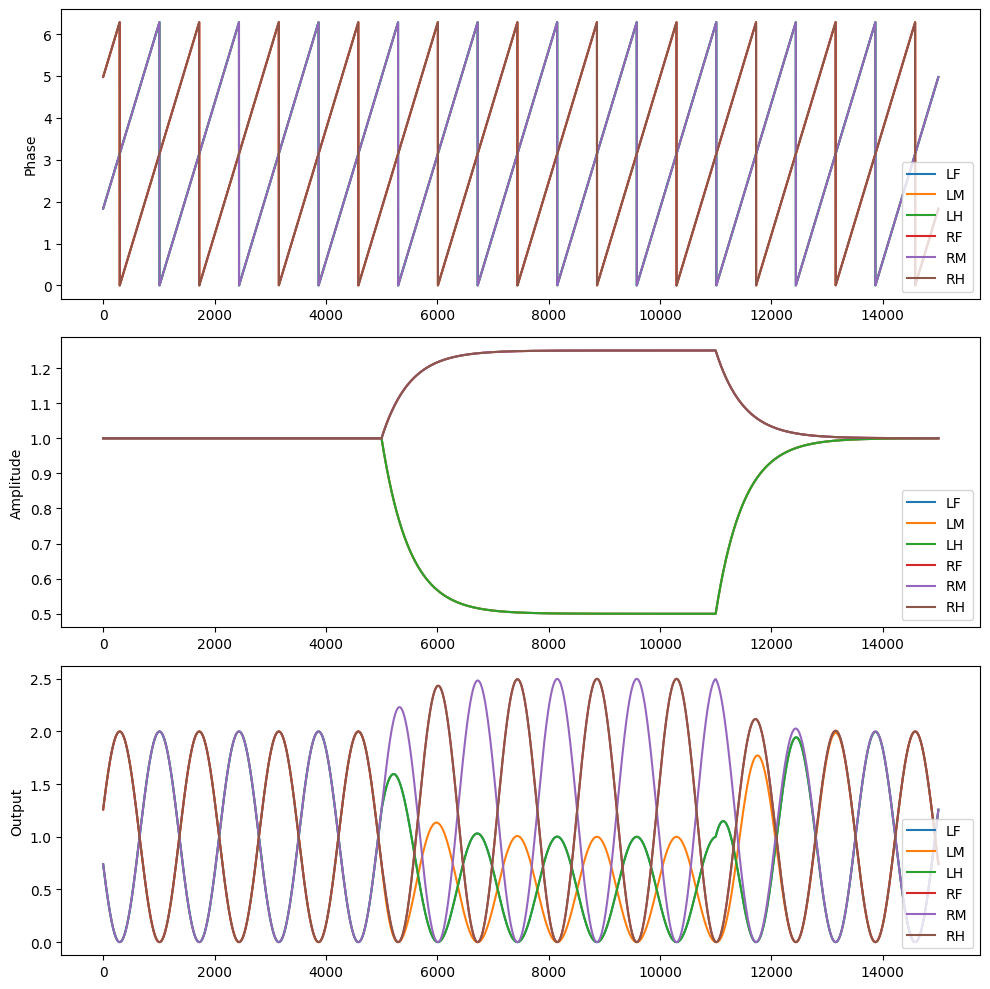

In [ ]:
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
plot_phase_amp_output(phases, amplitudes, sine_output(phases, amplitudes), legs)